# NFL Big Data Bowl 2022

**Authors**: Elizabeth G. Campolongo, Ranthony A.C. Edmonds, Kenneth Howe, Chaya Norton

In this notebook, we make use of topologically derived machine learning algorithms to perform a clustering analysis of high-resolution tracking data for two NFL Special Teams play types, namely field goals and extra points. The aim is to determine if the plays exhibit any intrinsic separation in their data that can be used to classify meaningful differences between plays (e.g. distinct strategies or outcomes).

## I. Getting the Initial Data

In [1]:
import pandas as pd

### 1. Importing the NFL Big Data Bowl Datasets

To start, we'll need data concerning the plays, games, and players.

In [2]:
plays = pd.read_csv('~/Documents/NFL/Data/plays.csv')
games = pd.read_csv('~/Documents/NFL/Data/games.csv')
players = pd.read_csv('~/Documents/NFL/Data/players.csv')

In [3]:
fg_tracking_2018 = pd.read_csv('~/Documents/NFL/Data/fg_tracking_2018.csv')
fg_tracking_2019 = pd.read_csv('~/Documents/NFL/Data/fg_tracking_2019.csv')
fg_tracking_2020 = pd.read_csv('~/Documents/NFL/Data/fg_tracking_2020.csv')

In [4]:
ep_tracking_2018 = pd.read_csv('~/Documents/NFL/Data/ep_tracking_2018.csv')
ep_tracking_2019 = pd.read_csv('~/Documents/NFL/Data/ep_tracking_2019.csv')
ep_tracking_2020 = pd.read_csv('~/Documents/NFL/Data/ep_tracking_2020.csv')

## II. Performing Initial Cleaning/Pre-Processing

To perform our analyses of field goal and extra point plays, we will need to prepare datasets containing the data regarding each play type. Before we assemble these datasets, it will be useful to perform some initial cleaning and pre-processing on the raw data that we just imported.

### 1. Pre-Processing Tracking Data

For the tracking data, we subdivide each of the tracking datasets into play-type specific DataFrames to reduce the scope of the larger DataFrames. We then isolate the tracking information relating only to the football across all three years and return it in its own DataFrame, dropping columns with information not available for the football itself (e.g. direction and angle).

In [5]:
from pipeline.preprocessing import preprocess_tracking, preprocess_football_track

In [6]:
# Pre-process field goal data
fg_tracking_2018, fg_tracking_2019, fg_tracking_2020 = preprocess_tracking(fg_tracking_2018, fg_tracking_2019, fg_tracking_2020, plays, 'Field Goal')
fg_tracking_ball = preprocess_football_track(fg_tracking_2018, fg_tracking_2019, fg_tracking_2020)

# Pre-process extra point data
ep_tracking_2018, ep_tracking_2019, ep_tracking_2020 = preprocess_tracking(ep_tracking_2018, ep_tracking_2019, ep_tracking_2020, plays, 'Extra Point')
ep_tracking_ball = preprocess_football_track(ep_tracking_2018, ep_tracking_2019, ep_tracking_2020)


### 2. Pre-Processing Play Data

For the play, we replace the game clock measurement with total elapsed game time measured in seconds and fill null values in the `penaltyYards` and `penaltyCodes` columns with "0" and "no penalty", respectively.

In [7]:
from pipeline.preprocessing import preprocess_play
from pipeline.preprocessing import drop_by_index_difference

In [8]:
play_df = preprocess_play(plays)

To eliminate plays with low-quality tracking data, we employ the following pre-processing function. In short, the function compares the labelled occasion of the given event with the moment that the event "actually" occurs (captured by the moment at which the ball reaches its maximum velocity). We discard any plays in which these two moments are substantially disparate.

### Example of Poor Quality Tracking Data:
![Bad Tracking Data](images/event_vs_ball_sa_bad.png)

### Example of Useful Quality Tracking Data:
![Good Tracking Data](images/event_vs_ball_sa_good.png)

Observe that the labeling for the moment of the kick ("FG Attempt") is not accurate based on velocity of the football.
Let idx<sub>M</sub> be the index corresponding to the maximum velocity of the football during the play and let idx<sub>L</sub> be the index labeled in the tracking data as the kick attempt ("FG Attempt" in example). We define the index difference to be:

$$\text{idx}_{\text{diff}} = |\text{idx}_M - \text{idx}_L|.$$

Since poor-quality data corresponds to a larger idx<sub>diff</sub>, this is how we will determine which data to remove. We set idx<sub>diff</sub> = 7, as that retains 90% of our data while maintaining reasonable quality.


Later, we will use this green region to determine the moment of the kick by taking the index of the greatest velocity within this range.

In [9]:
fg_play_df = drop_by_index_difference(play_df, fg_tracking_ball, 'field_goal_attempt')
ep_play_df = drop_by_index_difference(play_df, ep_tracking_ball, 'extra_point_attempt')

### 3. Pre-Process Players Data

The player data requires standardization of the height measurements from foot-inch to inches.

In [10]:
from pipeline.preprocessing import preprocess_players

In [11]:
players_df = preprocess_players(players)

## III. Constructing Play Type DataFrames

In [12]:
import numpy as np

from tabulate import tabulate

As mentioned above, we want to separate our data according to play type to perform analyses on each. Here we assemble datasets containing all of the relevant data for each play type (field goals and extra points).

In [13]:
from pipeline.dataset_builders import make_field_goal, make_extra_point

In [14]:
field_goal_df = make_field_goal(fg_play_df, players_df, fg_tracking_ball)
extra_point_df = make_extra_point(ep_play_df, players_df, ep_tracking_ball)

To reduce the amount of memory occupied by the very large tracking datasets, we have separated the tracking data according to each play type.

Here are the lists of columns that contain given data relevant to extra points and field goals.

In [15]:
fg_col_list = np.asarray(field_goal_df.columns).reshape(4,7).transpose()

ep_col_list = np.asarray(extra_point_df.columns)
ep_col_list = np.append(ep_col_list, '')
ep_col_list = ep_col_list.reshape(4,6).transpose()

In [16]:
print('Field Goal Columns:')
print(tabulate(fg_col_list))

print('\n')

print('Extra Point Columns')
print(tabulate(ep_col_list))

Field Goal Columns:
---------------  ------------------  --------------------  ----------------------
gameId           specialTeamsResult  penaltyCodes          playResult
playId           kickerId            penaltyJerseyNumbers  absoluteYardlineNumber
playDescription  returnerId          penaltyYards          gameClockSeconds
quarter          kickBlockerId       preSnapHomeScore      kicker_height
down             yardlineSide        preSnapVisitorScore   kicker_weight
yardsToGo        yardlineNumber      passResult            kicker_position
possessionTeam   gameClock           kickLength            kicker_name
---------------  ------------------  --------------------  ----------------------


Extra Point Columns
------------------  --------------  ----------------------  ----------------
gameId              kickerId        penaltyJerseyNumbers    gameClockSeconds
playId              kickBlockerId   penaltyYards            kicker_height
playDescription     yardlineSide    preSnapHom

## IV. Feature Engineering

![Football_Field_Axes.png](images/Football_Field_Axes.png)

In order to improve the results of our clustering and to add meaningful insights to our analyses, we generate a handful of meaningful engineered features:

   - `endzone_y`: The location of the kicked ball at the moment in which it crosses the 0 or 120 yard line.
   - `expected_endzone_y`: The expected location of the kicked ball at the moment in which it crosses the 0 or 120 yard line, extrapolated using a straight-line trajectory from the initial moments after the kick.
   - `endzone_y_off_center`: The distance between the `endzone_y` position and the centerline of the field goal posts.
   - `endzone_y_error` - The absolute difference between `expected_endzone_y` and `endzone_y` (i.e. intended vs. actual).
   - `kicker_core_distance_1`: The distance between the kicker and the closest player on the opposing team.
   - `kicker_core_distance_3`: The distance between the kicker and the third-closest player on the opposing team. (This serves as an approximation of the density of defensive players around the kicker.)

In [17]:
from pipeline.feature_engineering import endzone_y_pos, endzone_y_expected, endzone_y_off_center, endzone_y_error, kicker_core_dist

### 1. Endzone Y-Position

Given a set $S_p$ of football tracking data for a given play $p$, let 
$$E_{x} = \big\{x \in S_p: x \in (118,122)\big\}.$$

If $|E_x| = 2k$ for some positive integer $k$, then we set $\text{idx}_1 = k-1$ and $\text{idx}_2 = k$, else $|E_x| = 2k+1$ and we set $\text{idx}_1 = \text{idx}_2 = k-1$. Then the endzone y-position is
$$y_a \text{ defined as the }  y \text{ value of the football at index: } \frac{\text{idx}_1 + \text{idx}_2}{2}.$$

In [18]:
field_goal_df = endzone_y_pos(field_goal_df, fg_tracking_ball)
extra_point_df = endzone_y_pos(extra_point_df, ep_tracking_ball)

### 2. Endzone Y-Position Off-Center

Endzone y-position off-center is $|\frac{160}{6} - y_a|$. Since the width of the field (y direction) is 160ft, and our data is measured in yards.

In [19]:
field_goal_df = endzone_y_off_center(field_goal_df)
extra_point_df = endzone_y_off_center(extra_point_df)

### 3. Expected Endzone Y-Position

Let $x_1$ and $y_1$ be the respective $x$ and $y$ position of the football at the moment of the kick, and let $x_2$ and $y_2$ be the respective $x$ and $y$ position of the football two frames (0.2 seconds) later. Then
$$m = \frac{y_2-y_1}{x_2-x_1},$$

and we calculate the straight-line trajectory of the football so that the expected endzone y-position is:

$$y_e = m(120-x_1)+y_1.$$

In [20]:
field_goal_df = endzone_y_expected(field_goal_df, fg_tracking_ball, 'field_goal_attempt')
extra_point_df = endzone_y_expected(extra_point_df, ep_tracking_ball, 'extra_point_attempt')

### 4. Endzone Y-Position Error

Endzone y-position error is $|y_a-y_e|$.

In [21]:
field_goal_df = endzone_y_error(field_goal_df)
extra_point_df = endzone_y_error(extra_point_df)

### 5. Kicker Core Distances

![Kicker Core Distance](images/KickerCoreDist.png "Kicker Core Distance")

We use the $\ell_2$-norm to define distance $d$ between two points $(x_1,y_1),(x_2,y_2)$:

$$d = \sqrt{(x_2-x_1)^2 + (y_2-y_1)^2}.$$

From here we generate an ordered list, $D$, of distances of all defensive players from the kicker at the moment of the kick: 

$$D = \{d_1, d_2, \dots, d_{11}\} \text{ such that } d_1 \leq d_2 \leq \dots \leq d_{11}.$$

Then the $k$-th kicker core distance is $d_k$.

Thus, kicker core distance with `k=1` indicates the closest defensive player. We want to consider if one player breaks the offensive line.

In [22]:
# Kicker core distance 1
field_goal_df = kicker_core_dist(field_goal_df, fg_tracking_2018, fg_tracking_2019, fg_tracking_2020, fg_tracking_ball, 'field_goal_attempt', k=1)
extra_point_df = kicker_core_dist(extra_point_df, ep_tracking_2018, ep_tracking_2019, ep_tracking_2020, ep_tracking_ball, 'extra_point_attempt', k=1)

For each `specialTeamsResult`, we analyzed the variance and standard deviation of kicker core distances with parameter `k` ranging from 1-5, and found that `k=3` demonstrated the highest distinction between play results. Hence, we will use kicker core distance with `k=3` in our clustering.

In [23]:
# Kicker core distance 3
field_goal_df = kicker_core_dist(field_goal_df, fg_tracking_2018, fg_tracking_2019, fg_tracking_2020, fg_tracking_ball, 'field_goal_attempt', k=3)
extra_point_df = kicker_core_dist(extra_point_df, ep_tracking_2018, ep_tracking_2019, ep_tracking_2020, ep_tracking_ball, 'extra_point_attempt', k=3)

## V. Final Pre-Processing Steps

For clustering, we reduce the extra point and field goal dataframes to include only those features we wish to be considered in the clustering.

In [24]:
from pipeline.preprocessing import preprocess_fg, preprocess_ep

In [25]:
field_goal_X, field_goal_df = preprocess_fg(field_goal_df, encode_categorical=False)
extra_point_X, extra_point_df = preprocess_ep(extra_point_df, encode_categorical=False)

For the sake of creating a more meaningful embedding, it is important that we convert numerical features which act as categorical features to a data type that will be treated as categorical in our embedding algorithm.

For field goals, the `penaltyYards` and `down` columns act as effectively categorical features, as there are only a handful of discrete values they can take on, and the exact differences between values in these columns are not meaningful.

For extra points, the `penaltyYards` and `yardlineNumber` columns are those which act as effectively categorical.

In [26]:
field_goal_df['penaltyYards'] = field_goal_df['penaltyYards'].astype(str)
field_goal_df['down'] = field_goal_df['down'].astype(str)

field_goal_X['penaltyYards'] = field_goal_df['penaltyYards'].astype(str)
field_goal_X['down'] = field_goal_df['down'].astype(str)

In [27]:
extra_point_df['penaltyYards'] = extra_point_df['penaltyYards'].astype(str)
extra_point_df['yardlineNumber'] = extra_point_df['yardlineNumber'].astype(str)

extra_point_X['penaltyYards'] = extra_point_df['penaltyYards'].astype(str)
extra_point_X['yardlineNumber'] = extra_point_df['yardlineNumber'].astype(str)

## VI. Clustering with UMAP and HDBSCAN

Behind the scenes, our clustering is a process that occurs in two steps.

First, UMAP is used to embed our data into a "natural" lower-dimensional representation. Conveniently, UMAP allows us to synthesize different notions of distance for numeric and categorical data types, alleviating some of the problems inherent in using distance-metric-based clustering algorithms on mixed-type data. This is accomplished by creating two separate embeddings for our data: one for numeric and another for categorical. Different distance metrics are then used to construct two embeddings, the topological representations of which are combined and optimized to produce the final output in a three-dimensional space.

Once the data is embedded in this lower-dimensional space, HDBSCAN is then used to detect the clusters which are intrinsically present in the data.

To execute both of these steps using a single, easy-to-use model, we make use of the `Amazon-DenseClus` package.

In [28]:
from denseclus import DenseClus

### 1. Initialize the Models

In [29]:
field_goal_clf = DenseClus(umap_combine_method='intersection_union_mapper')
extra_point_clf = DenseClus(umap_combine_method='intersection_union_mapper')

### 2. Fit the Models

In [30]:
field_goal_clf.fit(field_goal_df)

/home/kenneth/anaconda3/envs/nfl-env/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


In [31]:
extra_point_clf.fit(extra_point_df)

/home/kenneth/anaconda3/envs/nfl-env/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


### 3. Add Cluster IDs to DataFrame

In [32]:
field_goal_df['cluster_id'] = field_goal_clf.score()
extra_point_df['cluster_id'] = extra_point_clf.score()

### 4. Create Cluster Dictionaries

In [33]:
# These dictionaries allow us to access the data in each cluster using the cluster_id as a key
fg_cluster_dict = {id: field_goal_df[field_goal_df['cluster_id']==id] for id in sorted(field_goal_df['cluster_id'].unique())}
ep_cluster_dict = {id: extra_point_df[extra_point_df['cluster_id']==id] for id in sorted(extra_point_df['cluster_id'].unique())}

## VII. Investigate Model Results

In [34]:
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import plotly.express as px

from IPython.display import Image
from matplotlib.pyplot import rcParams

/home/kenneth/anaconda3/envs/nfl-env/lib/python3.8/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [35]:
# Initialize Matplotlib styling parameters
plt.style.use('seaborn')
rcParams.update({
    'font.size': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'legend.fontsize': 12

})

### 1. Clustering Statistics

Here we produce a quick summary of what is in each cluster. Specifically, we are interested in whether our clusters separate nicely according to `specialTeamsResult`.

In [36]:
fg_num_clusters = field_goal_df['cluster_id'].max() + 1
ep_num_clusters = extra_point_df['cluster_id'].max() + 1

In [37]:
fg_num_outliers = field_goal_df['cluster_id'].value_counts()[-1]
ep_num_outliers = extra_point_df['cluster_id'].value_counts()[-1]

fg_percent_outliers = 100 * fg_num_outliers / len(field_goal_df['cluster_id'])
ep_percent_outliers = 100 * ep_num_outliers / len(extra_point_df['cluster_id'])

In [38]:
print('Field Goal Modeling Results:\n============================')
print(f'Number of Clusters: {fg_num_clusters}')
print(f'Number of Outliers: {fg_num_outliers} ({fg_percent_outliers:.2f}%)')
print(f'Special Teams Counts:\n{field_goal_df.groupby("cluster_id")["specialTeamsResult"].value_counts()}')

Field Goal Modeling Results:
Number of Clusters: 3
Number of Outliers: 52 (2.19%)
Special Teams Counts:
cluster_id  specialTeamsResult  
-1          Kick Attempt No Good      38
            Kick Attempt Good         14
 0          Kick Attempt Good       2015
            Kick Attempt No Good       2
 1          Kick Attempt No Good     172
 2          Kick Attempt No Good     136
Name: specialTeamsResult, dtype: int64


In [39]:
print('Extra Point Modeling Results:\n=============================')
print(f'Number of Clusters: {ep_num_clusters}')
print(f'Number of Outliers: {ep_num_outliers} ({ep_percent_outliers:.2f}%)')
print(f'Special Teams Counts:\n{extra_point_df.groupby("cluster_id")["specialTeamsResult"].value_counts()}')

Extra Point Modeling Results:
Number of Clusters: 3
Number of Outliers: 218 (6.80%)
Special Teams Counts:
cluster_id  specialTeamsResult  
-1          Kick Attempt Good        176
            Kick Attempt No Good      42
 0          Kick Attempt No Good     145
 1          Kick Attempt Good        154
 2          Kick Attempt Good       2687
            Kick Attempt No Good       1
Name: specialTeamsResult, dtype: int64


As desired, the clusters for each play type are divided nicely according to the result of each special teams play.

### 2. Visualize Results

Since we used UMAP to embed our data, we can visualize the embedding with a 3-dimensional plot. We can also examine the results of our HDBSCAN clustering by viewing the condensed tree plots for each clustering.

In [40]:
# Custom color sequence for clustering (helps assign outliers to grey color)
custom_color_seq = ['#777777']
custom_color_seq.extend(px.colors.qualitative.Plotly)

#### Field Goal UMAP Embedding

In [41]:
fg_umap_embedding = field_goal_clf.mapper_.embedding_
fg_umap_df = pd.DataFrame(fg_umap_embedding, columns=['x','y','z'])
fg_umap_df['cluster_id'] = field_goal_clf.score()
fg_groups = fg_umap_df.groupby('cluster_id')

In [42]:
fig = px.scatter_3d(
    fg_umap_df.sort_values(by='cluster_id'),
    x='x',
    y='y',
    z='z',
    color=field_goal_df['cluster_id'].sort_values().astype(str),
    color_discrete_sequence=custom_color_seq,
    title='Field Goal UMAP Embedding')
fig.update_traces(
    marker = dict(size=3)
)
fig.update_layout(
    autosize=False,
    width=900,
    height=900,
    legend_title='cluster_id'
)
fig.layout.coloraxis.colorbar.title = 'kicker_core_dist_3'
fig.show()


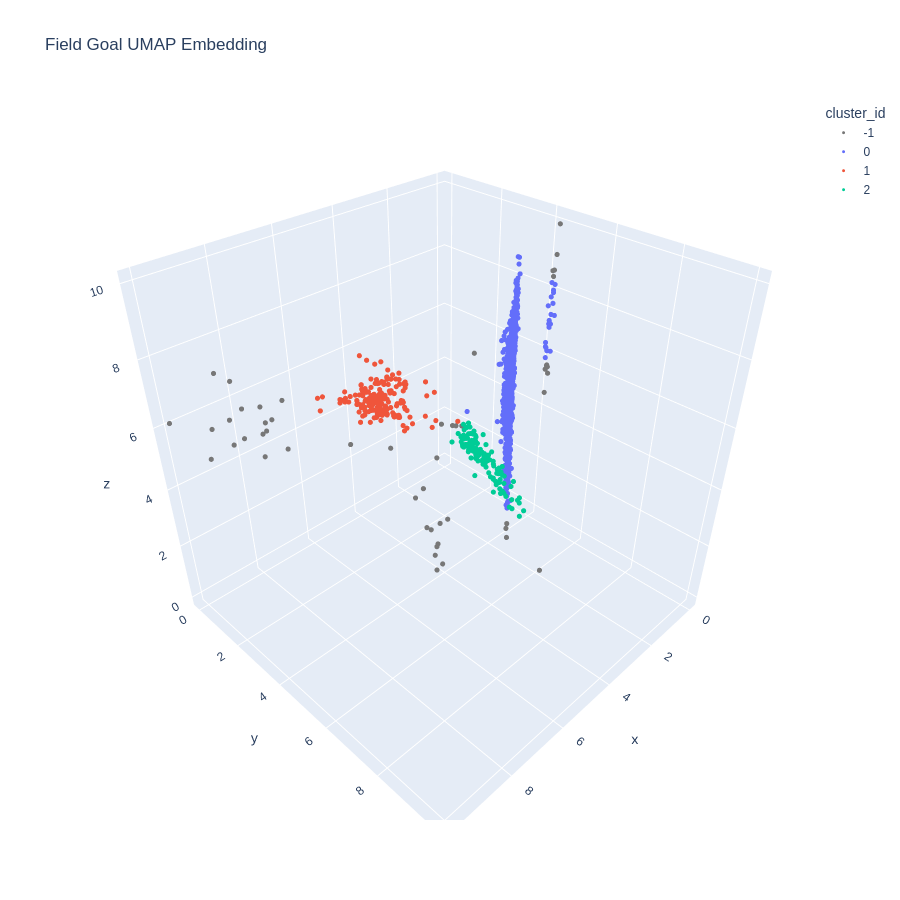

In [43]:
# Export and display as static image for GitHub viewing
image_bytes = fig.to_image(format='png')
Image(image_bytes)

In [44]:
fig = px.scatter_3d(
    fg_umap_df.sort_values(by='cluster_id'),
    x='x',
    y='y',
    z='z',
    color=field_goal_df['cluster_id'].sort_values().astype(str),
    color_discrete_sequence=custom_color_seq,
    title='Field Goal UMAP Embedding')
fig.update_traces(
    marker = dict(size=5)
)
fig.update_layout(
    autosize=False,
    width=900,
    height=900,
    legend_title='cluster_id',
    font=dict(size=18)
)
fig.layout.coloraxis.colorbar.title = 'kicker_core_dist_3'
fig.show()

#### Field Goal HDBSCAN Results

HDBSCAN selects clusters using a hierarchical dendogram structure constructed from an approximate density function on the dataset, in which each branch of the dendogram corresponds to some connected component of a level set of the approximated density function. The most persistent branches in this dendogram are assumed to be the most intrinsically meaningful, and are thus selected as the final clusters output by the algorithm.

We can visualize this dendogram to get an idea of how our data is separated and why HDBSCAN makes the cluster selection that it does.

Text(0.5, 1.0, 'HDBSCAN Condensed Tree (Field Goals)')

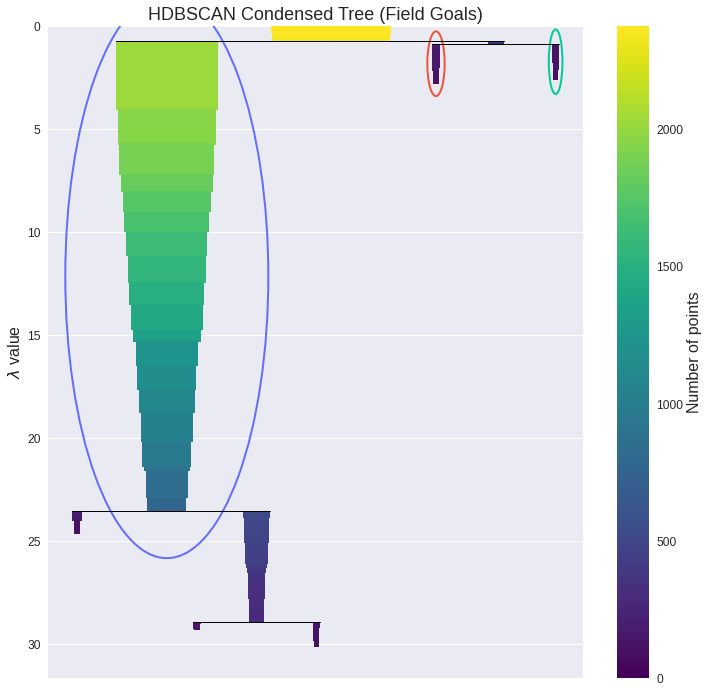

In [45]:
plt.figure(figsize=(12,12))

field_goal_clf.hdbscan_.condensed_tree_.plot(select_clusters=True, selection_palette=custom_color_seq[1:])

plt.title('HDBSCAN Condensed Tree (Field Goals)')

#plt.savefig('fg_hdbscan_tree.png')

We see the three field goal clusters being selected due to their persistence in the dendogram, as well as their relative sizes.

#### Extra Point UMAP Embedding

In [46]:
ep_umap_embedding = extra_point_clf.mapper_.embedding_
ep_umap_df = pd.DataFrame(ep_umap_embedding, columns=['x','y','z'])
ep_umap_df['cluster_id'] = extra_point_clf.score()
ep_groups = ep_umap_df.groupby('cluster_id')

In [47]:
fig = px.scatter_3d(
    ep_umap_df.sort_values(by='cluster_id'),
    x='x',
    y='y',
    z='z',
    color=extra_point_df['cluster_id'].sort_values().astype(str),
    color_discrete_sequence=custom_color_seq,
    title='Extra Point UMAP Embedding'
)
fig.update_traces(
    marker = dict(size=3)
)
fig.update_layout(
    autosize=False,
    width=900,
    height=900,
    legend_title='cluster_id'
)


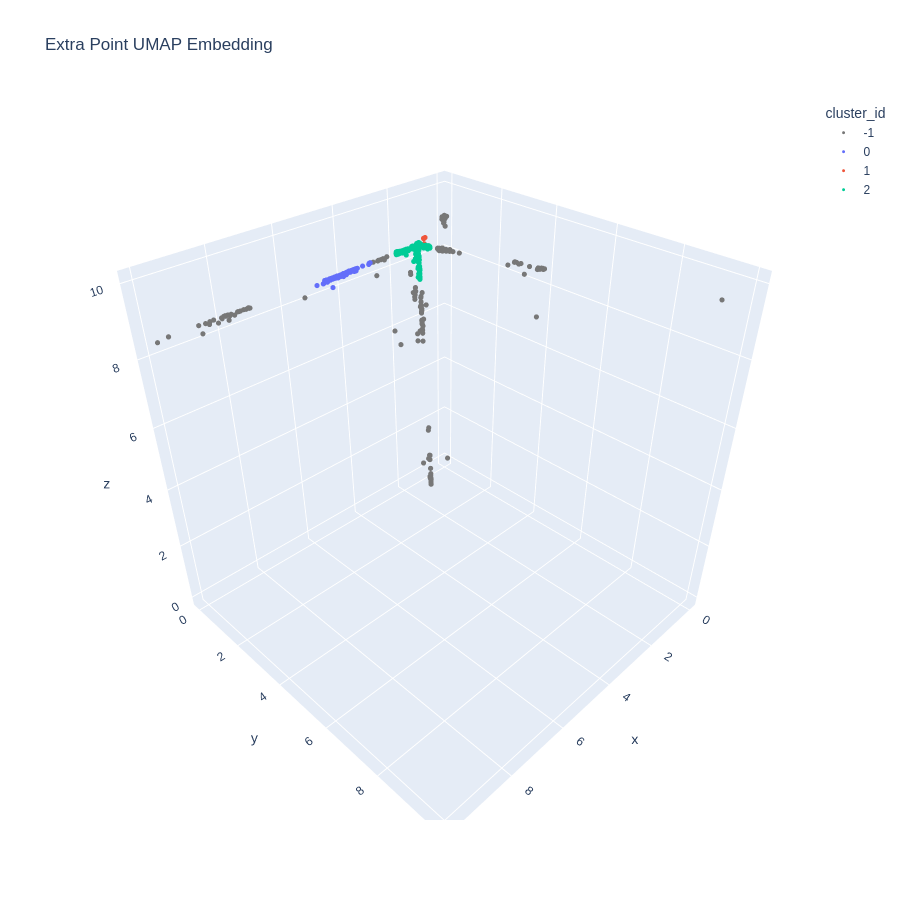

In [48]:
# Export and display as static image for GitHub viewing
image_bytes = fig.to_image(format='png')
Image(image_bytes)

#### Extra Point HDBSCAN Results

Text(0.5, 1.0, 'HDBSCAN Condensed Tree (Extra Points)')

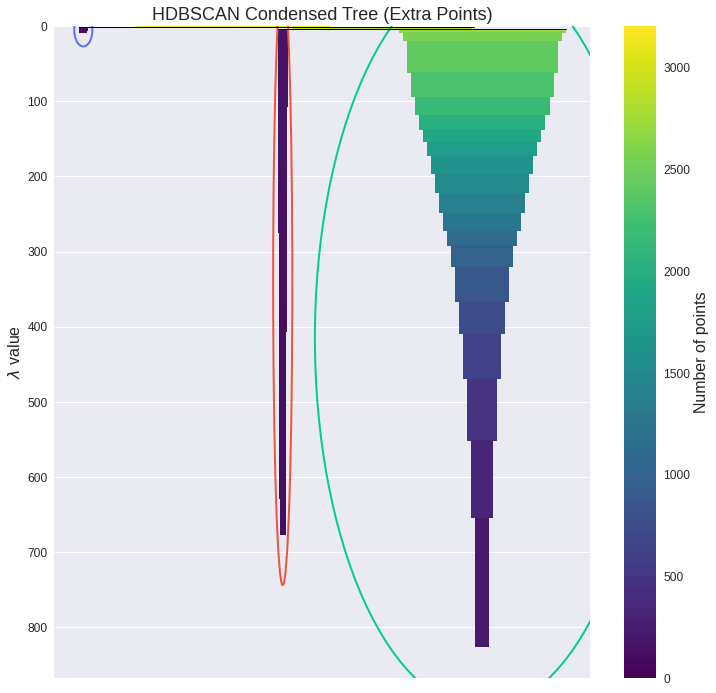

In [49]:
plt.figure(figsize=(12,12))

extra_point_clf.hdbscan_.condensed_tree_.plot(select_clusters=True, selection_palette=custom_color_seq[1:])

plt.title('HDBSCAN Condensed Tree (Extra Points)')

#plt.savefig('ep_hdbscan_tree.png')

Again, we see HDBSCAN selecting three distinct clusters due to their persistence in the dendogram, as well as their relative sizes.

### 3. Investigate Cluster Contents

In [50]:
from sklearn.linear_model import LinearRegression, LogisticRegression

The results of our field goal embedding and clustering indicate that the vast majority of the high-dimensional structure in our data can be explained with two or three of the features.

Since `endzone_y` appears to be our most meaningful numerical feature, lets see how it breaks up according to our generated clusters.

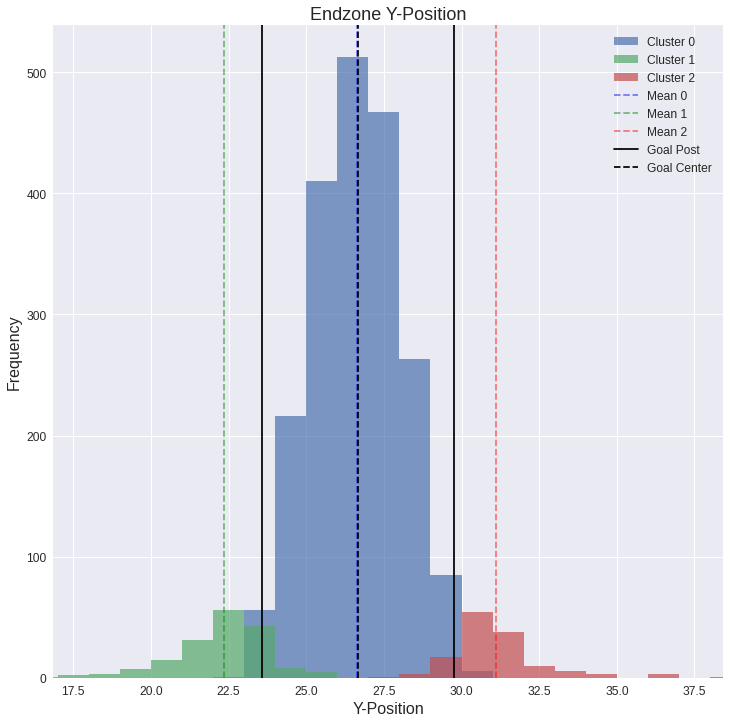

In [51]:
center = 160 / 6 # Center of field goal posts
radius = 37/12 # Halved distance between posts

plt.figure(figsize=(12,12))

plt.xlim(fg_cluster_dict[1]['endzone_y'].min(), fg_cluster_dict[2]['endzone_y'].max())

plt.hist(fg_cluster_dict[0]['endzone_y'], bins=range(54), alpha=0.7, label='Cluster 0')
plt.hist(fg_cluster_dict[1]['endzone_y'], bins=range(54), alpha=0.7, label='Cluster 1')
plt.hist(fg_cluster_dict[2]['endzone_y'], bins=range(54), alpha=0.7, label='Cluster 2')

plt.axvline(x=fg_cluster_dict[0]['endzone_y'].mean(), color='blue', linestyle='--', alpha=0.5, label='Mean 0')
plt.axvline(x=fg_cluster_dict[1]['endzone_y'].mean(), color='green', linestyle='--', alpha=0.5, label='Mean 1')
plt.axvline(x=fg_cluster_dict[2]['endzone_y'].mean(), color='red', linestyle='--', alpha=0.5, label='Mean 2')

plt.axvline(x=center-radius, color='black', label='Goal Post')
plt.axvline(x=center+radius, color='black')
plt.axvline(x=160/6, color='black', label='Goal Center', linestyle='--')

plt.title('Endzone Y-Position')
plt.xlabel('Y-Position')
plt.ylabel('Frequency')

plt.legend()

plt.savefig('fg_cluster_endzone_y.png')

### 4. Statistical Analysis of UMAP Axes

We also should statistically verify the relationship between the UMAP axes from our field goal embedding and the features we hypothesize they represent. This will verify that our axes are straightforwardly interpretable.

**Note:** The axes in the Extra Point UMAP embedding do not appear to meaningfully correlate with any individual features in the dataset.

#### Linear Regression on UMAP Y-Axis and Endzone Y Position

We suspect that there is an approximately linear relationship between the UMAP y-axis and our `endzone_y` column. We use linear regression to verify this.

In [52]:
X = np.asarray(field_goal_df['endzone_y']).reshape(-1,1)
y = np.asarray(fg_umap_df['y'])

regressor = LinearRegression()

regressor.fit(X, y)

reg_m = regressor.coef_[0]
reg_b = regressor.intercept_
reg_corr = regressor.score(X, y)

print(f'Equation: {reg_m:.4f} * x + {reg_b:.4f}')
print(f'Corr. Coeff.: {reg_corr:.4f}')

Equation: 0.2784 * x + -2.9478
Corr. Coeff.: 0.5551


Text(0.5, 1.0, 'Axis-Feature Correlation')

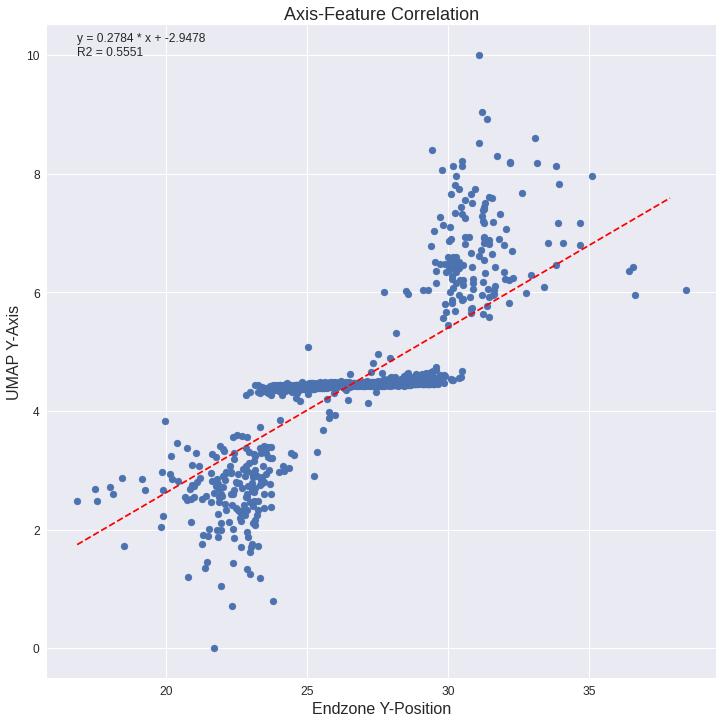

In [53]:
fig, ax = plt.subplots(1,1)

fig.set_figwidth(12)
fig.set_figheight(12)

ax.scatter(x=field_goal_df['endzone_y'], y=fg_umap_df['y'])

reg_x = np.arange(field_goal_df['endzone_y'].min(), field_goal_df['endzone_y'].max()).reshape(-1,1)
reg_y = regressor.predict(reg_x)

ax.plot(reg_x, reg_y, color='red', linestyle='--')

ax.set_xlabel('Endzone Y-Position')
ax.set_ylabel('UMAP Y-Axis')

top_x = field_goal_df['endzone_y'].min()
top_y = fg_umap_df['y'].max()

ax.text(top_x, top_y, f'y = {reg_m:.4f} * x + {reg_b:.4f}\nR2 = {reg_corr:.4f}')

ax.set_title('Axis-Feature Correlation')

#### Logistic Regression on UMAP X-Axis and Special Teams Result

We can use logistic regression to determine the relationship between a continuous numerical feature (the UMAP x-axis) and a binary categorical feature (the play result).

In [54]:
# We will need to encode the specialTeamsResult columns to perform logistic regression
X = np.asarray(fg_umap_df['x']).reshape(-1,1)
y = np.asarray(field_goal_df['specialTeamsResult'].map(lambda x: 1 if x == 'Kick Attempt Good' else 0))

regressor = LogisticRegression()

regressor.fit(X, y)

print(f'Corr. Coeff.: {regressor.score(X, y):.4f}')

Corr. Coeff.: 0.9987


Text(0.5, 1.0, 'Axis-Feature Correlation')

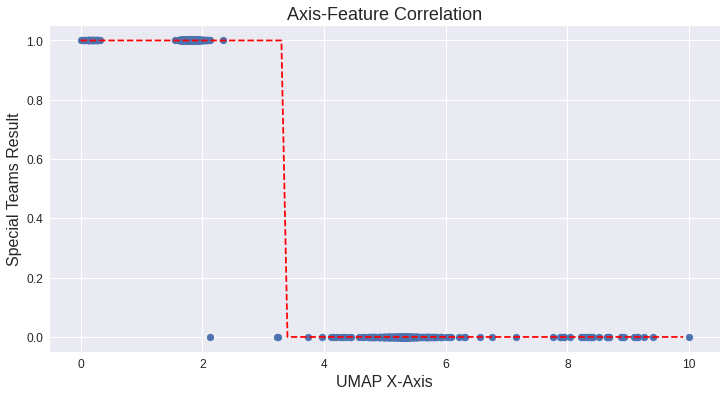

In [55]:
fig, ax = plt.subplots(1,1)

fig.set_figwidth(12)
fig.set_figheight(6)

ax.scatter(x=fg_umap_df['x'], y=y)

reg_x = np.arange(fg_umap_df['x'].min(), fg_umap_df['x'].max(), 0.1).reshape(-1,1)
reg_y = regressor.predict(reg_x)

ax.plot(reg_x, reg_y, color='red', linestyle='--')

ax.set_xlabel('UMAP X-Axis')
ax.set_ylabel('Special Teams Result')

ax.set_title('Axis-Feature Correlation')